04/11 to 04/18

# Trajectory generating

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy.random as rd
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise

In [2]:
dt=0.1

# Constant velocity: EKF 

just an example

In [3]:

def HJacobian_at(x):
    """ compute Jacobian of H matrix at x """
    
    return  np.array([[1.,0,0,0],[0,1,0,0]])
def Hx(x):
    return np.array([x[0],x[1]])
def Constant_velocity_EKF(itr):
        
    dt = 0.1
    F = np.array([[1, 0, dt, 0], [0, 1, 0, dt],[0,0,1,0],[0,0,0,1]])
    # Process Noise Covariance
    sv = 0.1
    G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])
    Q = G*G.T*sv**2
    R = 3.*np.eye(2)
    real_state = []
    x = np.array([0,0,4,5]).reshape(4,1)
    measurements = []
    #process(motion) model 
    #observation model
    for i in range(itr):
        real_state.append(x)
        x = np.dot(F,x)+np.random.multivariate_normal(mean=(0,0,0,0),cov=Q).reshape(4,1)
        measurements.append(np.array(x[0:2,:]+np.random.multivariate_normal(mean=(0,0),cov=R).reshape(2,1)))
    
    # initialization
    P = 5*np.eye(4)
    x0=np.random.multivariate_normal(mean=(0,0,0,0),cov=P).reshape(4,1)
    
    #filter
    kf =ExtendedKalmanFilter(dim_x=4, dim_z=2) 
    #parameters
    kf.x = x0 #
    kf.F = F #
    kf.H = np.array([[1.,0,0,0],[0,1,0,0]])  #
    kf.P = P #
    kf.R = R #
#     kf.Q = Q_discrete_white_noise(dim=4, dt=dt, var=2e-2) 
    kf.Q = np.array(Q)

    filter_result=list()
    filter_result.append(x)
    for i in range(1,itr):
        z = measurements[i]
#         print(z)
        kf.predict()
        kf.update(z,HJacobian_at,Hx)
        filter_result.append(kf.x)
    filter_result=np.squeeze(np.array(filter_result))
    
    measurements = np.array(measurements)
    real_state = np.array(real_state)
    filter_result = np.array(filter_result)
    return measurements,real_state,filter_result
def plot_result(measurements,real_state,filter_result):
    
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,0], label = 'Real state',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,0], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.legend()
    plt.subplot(222)
    plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,1], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,1], label = 'Real state',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,1], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.legend()
    plt.subplot(223)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,2], label = 'Ground truth',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,2], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-velocity [m/s]',fontsize=14)
    plt.ylim(ymin=0)
    plt.legend()
    plt.subplot(224)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,3], label = 'Ground truth',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,3], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-velocity [m/s]',fontsize=14)
    plt.ylim(ymin=0)
    plt.legend()



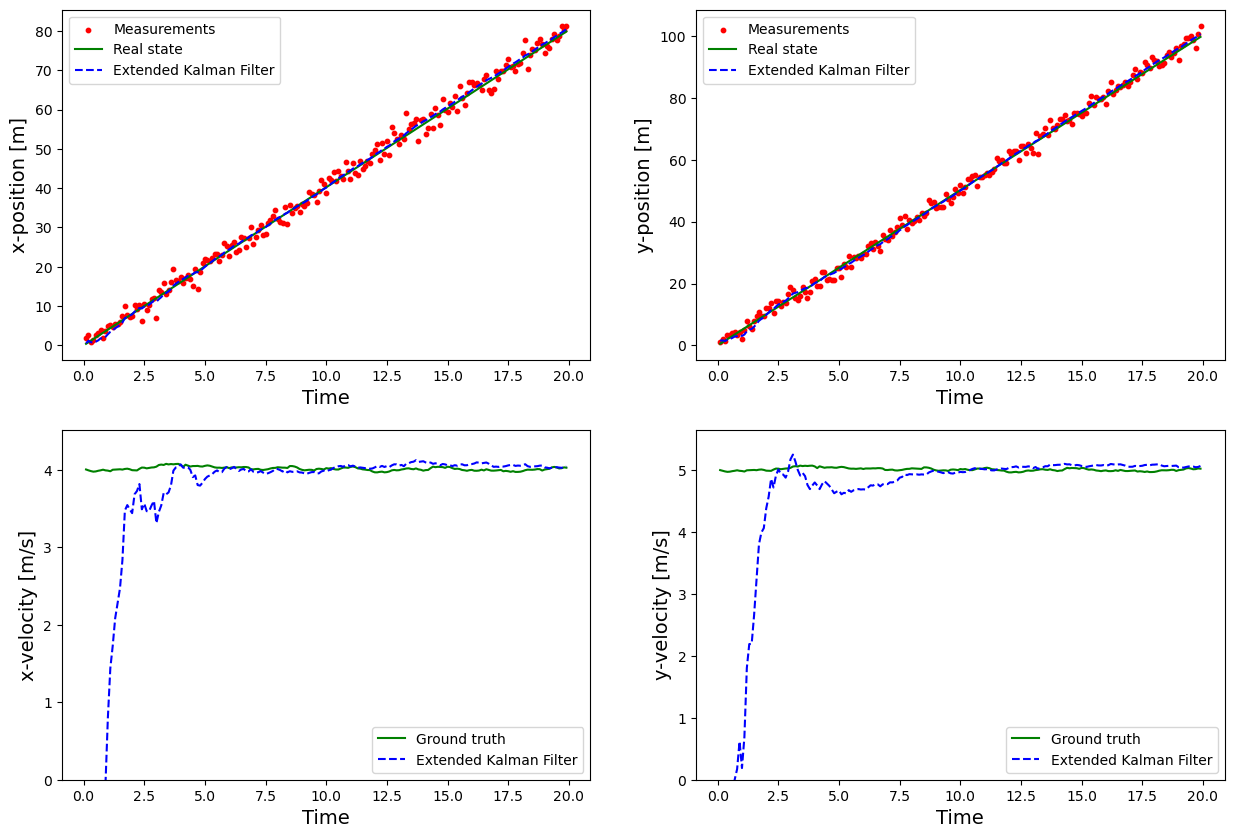

In [4]:
# measurements,real_state,filter_result=demo()
# plot_result(measurements,real_state,filter_result)
measurements,real_state,filter_result = Constant_velocity_EKF(itr=200)
plot_result(measurements,real_state,filter_result)
# print(measurements.shape,real_state.shape,filter_result.shape)
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF.png')


# Constant velocity+ phase model : EKF prior + ML

In [5]:
def array(num_elements,dim,x_start):
    lin_array=np.zeros((num_elements,2))
    lin_array[:,0]=[i for i in np.linspace(x_start,x_start+dim,num_elements)]#y_axis
    lin_array[:,1]=[ 0 for _ in range(num_elements)]#x_axis
    return lin_array
def near_field_Boundary(lamb,arr_dim):
    return 2*arr_dim**2/lamb

def sample_in_half_circle(R,N):
    samples=np.zeros((N,2))
    count=0
    while(count<N):       
        x=(np.random.uniform(0,1,1)-0.5)*2*R#U[-R,R]
        y=np.random.uniform(0,1,1)*R# U[0,R]
        if(x**2+y**2<=R**2):
            samples[count]=np.array([x,y]).reshape(2,)
            count+=1
    return samples
class ML:
    def ML_grid(self,xrange,yrange,phase_obs,arr,lamb,resolution,flag_plot=True):
        
        N=arr.shape[0]
        num_grid_x=int(np.floor((xrange[1]-xrange[0])/resolution))+1
        num_grid_y=int(np.floor((yrange[1]-yrange[0])/resolution))+1

        grid_x, step_x=np.linspace(xrange[0],xrange[1],num_grid_x,retstep=True)
        grid_y, step_y=np.linspace(yrange[0],yrange[1],num_grid_y,retstep=True)
        
        objective_values=np.zeros((num_grid_x,num_grid_y))
        for i in range(num_grid_x):
            for j in range(num_grid_y):
                p=np.array([grid_x[i],grid_y[j]])
                distance=np.array([np.linalg.norm(arr[k]-p) for k in range(N)])
                phase_obs_diff=phase_obs-phase_obs[0]
                phase_model_diff=4*np.pi/lamb*(distance-distance[0])
                objective_values[i,j]=np.cos(phase_obs_diff-phase_model_diff).sum()

        a,b=np.where(objective_values==np.max(objective_values))
        loc=np.array([grid_x[a[0]],grid_y[b[0]]])
        
        
#         print(f"ML estimation is{loc}")


        if(flag_plot):
            fig,ax=plt.subplots(figsize=(8,6))
            df = pd.DataFrame( objective_values.T,
                          columns=np.round(grid_x,3),
                          index=np.round(grid_y,3)
                          )
            #plotting
            sns.set_context({"figure.figsize":(5,5)})
            sns.heatmap(data=df,square=True,cmap="gist_gray")

            #ax.axes.yaxis.set_ticks([])
            #ax.axes.xaxis.set_ticks([])
            plt.xlabel('x')
            plt.ylabel('y')

            plt.scatter(a,b,c="red")
            plt.title(f'Grid searching result with resolution= {resolution/lamb}wavelength')
        
        loc=loc.reshape([-1,2])

        return np.array([num_grid_x,num_grid_y]),loc
    
    def ML_grid2(self,xrange,yrange,phase_obs,arr,lamb,resolution,num_ite,flag_plot=True):
        #hierarchical grid searching
        reso=resolution
        search_left_bound=xrange[0]
        search_right_bound=xrange[1]
        search_lower_bound=yrange[0]
        search_upper_bound=yrange[1]
        locs=[]
        
        for k in range(num_ite):
            
            num_grid_x=int(np.floor((search_right_bound-search_left_bound)/reso))
            num_grid_y=int(np.floor((search_upper_bound-search_lower_bound)/reso))

#             print(num_grid_x,num_grid_y)
            
            
            grid_x=np.arange(search_left_bound+0.5*reso,search_left_bound+(num_grid_x)*reso,reso)
            grid_y=np.arange(search_lower_bound+0.5*reso,search_lower_bound+(num_grid_y)*reso,reso)
#             print(len(grid_x),len(grid_y))
            objective_values=np.zeros((num_grid_x,num_grid_y))
            for i in range(num_grid_x):
                for j in range(num_grid_y):
                    p=np.array([grid_x[i],grid_y[j]])
                    distance=np.array([np.linalg.norm(arr[k]-p) for k in range(N)])
                    phase_obs_diff=phase_obs-phase_obs[0]
                    phase_model_diff=4*np.pi/lamb*(distance-distance[0])
                    objective_values[i,j]=np.cos(phase_obs_diff-phase_model_diff).sum()

            a,b=np.where(objective_values==np.max(objective_values))
            loc=np.array([grid_x[a[0]],grid_y[b[0]]])
            locs=np.append(locs, loc)


            if(flag_plot):
                plt.figure()
                fig,ax=plt.subplots(figsize=(8,6))
                df = pd.DataFrame( objective_values.T,
                              columns=np.round(grid_x,3),
                              index=np.round(grid_y,3)
                              )
                #plotting
                sns.set_context({"figure.figsize":(5,5)})
                sns.heatmap(data=df,square=True,annot=False,cmap="gist_gray")

                plt.xlabel('x')
                plt.ylabel('y')

                plt.text(a+0.5,b+0.5,'target',c="red",ha='center',va='center')
                ax.add_patch(plt.Rectangle((a-2,b-2), 5,5, color="blue", fill=False, linewidth=1))
                plt.title(f'Searching result with resolution= {reso/lamb}wavelength,ite={k+1}')

#                 plt.savefig(f'C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_4/ML2_Result_{k+1}.png')
            
            #increase the resolution and search within the best grid
            
            search_left_bound=max(loc[0]-reso*2.5,search_left_bound)
            search_right_bound=min(loc[0]+reso*2.5,search_right_bound)
            search_lower_bound=max(loc[1]-reso*2.5,search_lower_bound)
            search_upper_bound=min(loc[1]+reso*2.5,search_upper_bound)
            reso=0.25*reso
#             print(reso,search_left_bound,search_right_bound,search_lower_bound,search_upper_bound)
            
        locs=locs.reshape([-1,2])
        return np.max(objective_values),locs
    
    def plotting(self,size,f,targets,Loc_MLgrid,xrange,yrange):
        plt.figure(figsize=(4,4))
        plt.scatter(arr[:,0],arr[:,1],color='black')
        for i in range(len(targets)):
            plt.scatter(targets[i,0],targets[i,1],color='green',s=size)
        for j in range(Loc_MLgrid.shape[0]):
            plt.scatter(Loc_MLgrid[j,0],Loc_MLgrid[j,1],color='red',s=size)
            plt.text(Loc_MLgrid[j,0],Loc_MLgrid[j,1],j+1)
        plt.scatter(Loc_MLgrid[0],Loc_MLgrid[1],color='red',s=size)
        plt.title('ML result',fontsize=f)
        plt.legend(['array','true','loc_grid'],loc='upper left',fontsize=f)
        plt.xlim([xrange[0],xrange[1]])
        plt.ylim([yrange[0],yrange[1]])
        plt.xlabel('x axis [m]',fontsize=f)
        plt.ylabel('y axis [m]',fontsize=f)
        

In [16]:
# generate trajectory

def Calcphases(measurements,array,lmb,Phase_0):
    # n: number of antenna elements
    # Setsize: Length of trajectory
    n =array.shape[0]
    length=len(measurements)
    phases = np.zeros((length, n))
    
    if length > 1:
         for i in range(length):
            for j in range(n):
                distancetoantenna = np.linalg.norm(measurements[i]-array[j])
                phases[i, j] = (distancetoantenna * 4*math.pi/lmb + Phase_0) % (2*math.pi)
    if length == 1:
        phases = np.zeros(1,n)
        for j in range(n):
            distancetoantenna = np.linalg.norm(measurements-array[j].numpy())
            phases[0,j] = (distancetoantenna * 4*math.pi/lmb + Phase_0) % (2*math.pi)
    return phases
def GenerateTraj(Length,dt,X0,H,F,Q,R):

    real_state = []
    measurements = []
    #process(motion) model 
    #observation model
    x = X0
    for i in range(Length):
        real_state.append(x)
        x = np.dot(F,x)+np.random.multivariate_normal(mean=(0,0,0,0),cov=Q).reshape(4,1)
        measurements.append(np.array(x[0:2,:]+np.random.multivariate_normal(mean=(0,0),cov=R).reshape(2,1)))
    measurements = np.array(measurements).squeeze()
    real_state = np.array(real_state)
    lmb=2e-3
    #array of antennas
    N=10 # number of elements
    d=0.25*lmb # distance between 2 adjacent elements
    arr_dim=d*(N-1) # dimension of the array
    arr=array(N,arr_dim,0) # array elements location
    #
    Phases = Calcphases(measurements, arr,lmb,0)
    return real_state,measurements,Phases


In [17]:
# # showing the phase measurements
# X0=np.array([0,0,4,5]).reshape(4,1)
# real_state, measurements, Phases = GenerateTraj(10,X0)

# plt.figure(figsize=(10,10))
# plt.subplot(221)
# plt.plot(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements')
# plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,0], label = 'Real state',c='g' )
# plt.xlabel('Time',fontsize=14)
# plt.ylabel('x-position [m]',fontsize=14)
# plt.legend()
# plt.subplot(222)
# plt.plot(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,1], label = 'Measurements')
# plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,1], label = 'Real state',c='g' )
# plt.xlabel('Time',fontsize=14)
# plt.ylabel('y-position [m]',fontsize=14)
# plt.legend()

# plt.subplot(212)
# plt.plot(np.arange(1*dt,len(measurements)*dt,dt),Phases [1:,0], label = 'Phase Measurements')
# plt.xlabel('Time',fontsize=14)
# plt.ylabel('Phases at antenna 0 [rad]',fontsize=14)
# plt.legend()

# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/trajectory.png')


In [96]:
import pandas as pd
import seaborn as sns
def HJacobian_at(x):
    """ compute Jacobian of H matrix at x """
    
    return  np.array([[1.,0,0,0],[0,1,0,0]])
def Hx(x):
    return np.array([x[0],x[1]])
def Contant_velocity_EKF_ML(itr,dt,x0,P0,F,H,Q,R,lmb,ml_resol,std,arr,flag):
    #flag=1 normal EKF
    #dt,x0,P0,F,H,Q,R
    #flag=2 ml
    #lmb,ml_resol,std,arr,
#     x = np.array([0,0,4,5]).reshape(4,1)
    
    #filter
    kf =ExtendedKalmanFilter(dim_x=4, dim_z=2) 
    #定义参数 
    kf.x = x0 #
    kf.P = P0
    kf.F = F
    kf.H = H
    kf.Q = Q
    kf.R = R
    

    #KF filter
    filter_result=list()
    filter_result.append(x0)
    z_k_list = [] #start at z_k1
    
    for i in range(1,itr):
        
        #predict
        kf.predict()#get x_k|x_k-1
        
        if(flag==1):
            z_k_list.append(measurements[i].reshape(2,1))
            z = measurements[i,:,np.newaxis]
            
        if(flag==2):
            # kf_xprior as prior knowledge for ML estimator
            xrange=np.array([kf.x_prior[0,0]-3*std,kf.x_prior[0,0]+3*std])
            yrange=np.array([kf.x_prior[1,0]-3*std,kf.x_prior[1,0]+3*std])
            y_k=Phases[i,:]
            # ML
            ml=ML();
            num_grid,Loc_MLgrid=ml.ML_grid(xrange,yrange,y_k,arr,lmb,resolution=ml_resol,flag_plot=False)
            z_k_list.append(Loc_MLgrid.reshape(2,1)) #z_k
            z =Loc_MLgrid[0,:,np.newaxis]
        
        #update
        kf.update(z,HJacobian_at,Hx)
        filter_result.append(kf.x)
#     print(filter_result)
    filter_result=np.squeeze(np.array(filter_result))
    z_k_list = np.array(z_k_list)
    return z_k_list,filter_result


lmb:0.3488372093023256
(200, 2)
(199, 2, 1)


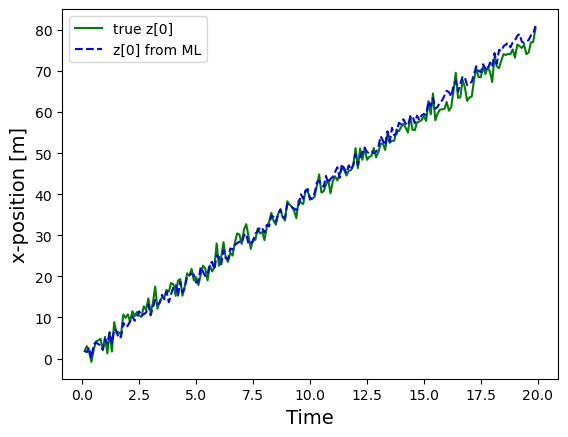

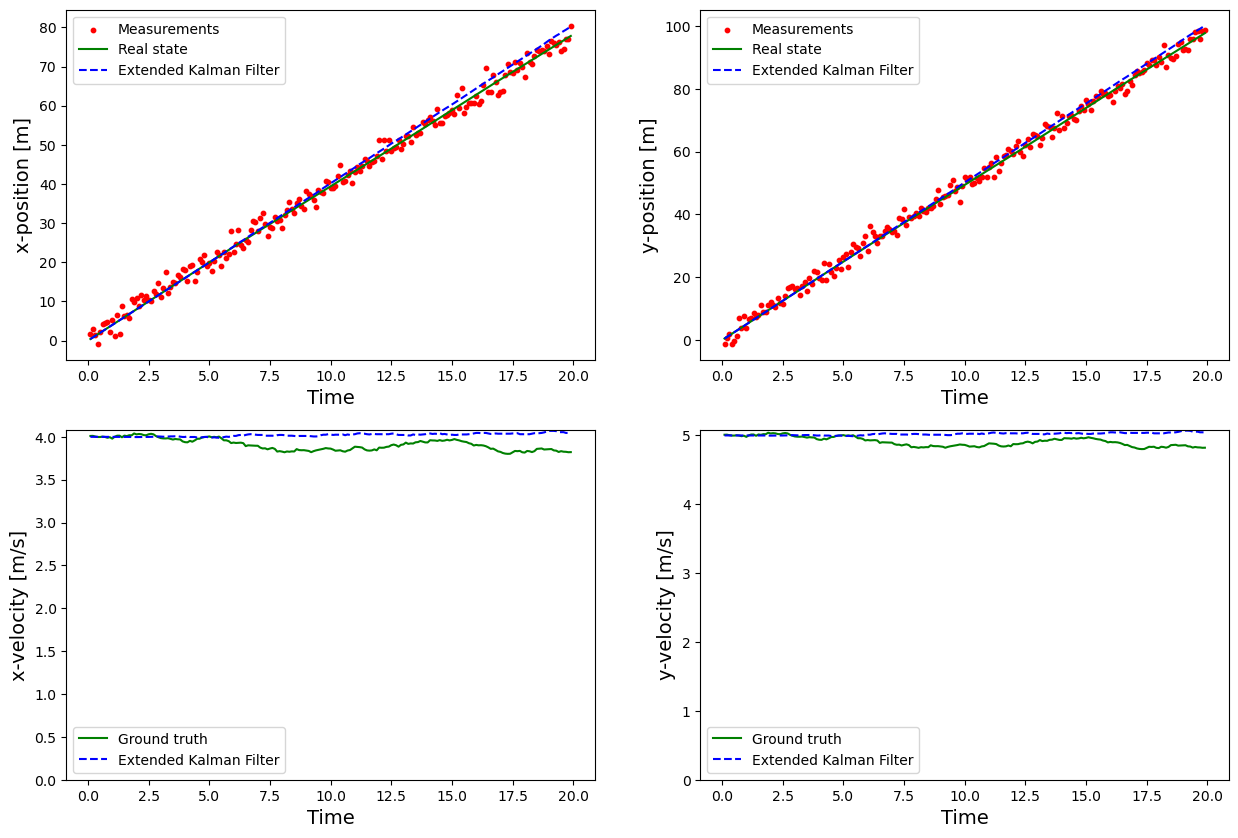

In [97]:
# ML parameters
f=8.6e8
lmb = 3e8/f
print(f'lmb:{lmb}')
ml_resol=2*lmb
std=0.5e0 #extremely important !0.5 is best, 1 is worse (larger, worse)
# array paramters
N=10 # number of elements
d=0.25*lmb # distance between 2 adjacent elements
arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location
# Trajectory Parameters
X0=np.array([0,0,4,5]).reshape(4,1)
Length= 200
dt = 0.1
F = np.array([[1, 0, dt, 0], [0, 1, 0, dt],[0,0,1,0],[0,0,0,1]])
H=np.array([[1.,0,0,0],[0,1,0,0]])  
# Process Noise Covariance
sv = 0.1
G = np.matrix([[0.5*dt**2],
           [0.5*dt**2],
           [dt],
           [dt]])
Q = G*G.T*sv**2
Q = np.array(Q)
R = 3.*np.eye(2)

#init
# x0=np.random.multivariate_normal(mean=(0,0,2,3),cov=P).reshape(4,1)
# x0_EKF =np.array([0,0,3,5.1]).reshape(4,1) #important!
# P0_EKF = 5*np.eye(4)
x0_EKF = X0
P0_EKF=np.zeros([4,4])

real_state, measurements, Phases = GenerateTraj(Length,dt,X0,H,F,Q,R)
z_ML,filter_result_ML = Contant_velocity_EKF_ML(itr=Length,dt=dt,x0=x0_EKF,P0=P0_EKF,F=F,H=H,Q=Q,R=R,
                                                lmb=lmb,ml_resol=ml_resol,std=std,arr=arr,flag=2)
print(measurements.shape)

# Compare real z and z estimated from ML
print(z_ML.shape)
plt.figure()
plt.plot(np.arange(1*dt,len(measurements)*dt,dt),measurements[1:,0],label = 'true z[0]',c='g')
plt.plot(np.arange(1*dt,len(measurements)*dt,dt),z_ML[:,0,0],label = 'z[0] from ML',c='b',linestyle='--')
plt.xlabel('Time',fontsize=14)
plt.ylabel('x-position [m]',fontsize=14)
plt.legend()
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_z.png')
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_z_bad.png')


#plotting result
plot_result(measurements,real_state,filter_result_ML)
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_result.png')
# plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_result_bad.png')

In [98]:
def plot_result_compare(measurements,real_state,filter_result,filter_result_ML):
    
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,0], label = 'Real state',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,0], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result_ML[1:,0], label = 'Extended Kalman Filter + ML encoder',c='black',linestyle='-.')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.legend()
    plt.subplot(222)
    plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,1], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,1], label = 'Real state',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,1], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result_ML[1:,1], label = 'Extended Kalman Filter + ML encoder',c='black',linestyle='-.')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.legend()
    plt.subplot(223)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,2], label = 'Ground truth',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,2], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result_ML[1:,2], label = 'Extended Kalman Filter + ML encoder',c='black',linestyle='-.')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('x-velocity [m/s]',fontsize=14)
    plt.ylim(ymin=3,ymax=6)
    plt.legend()
    plt.subplot(224)
    plt.plot(np.arange(1*dt,len(real_state)*dt,dt), real_state[1:,3], label = 'Ground truth',c='g' )
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,3], label = 'Extended Kalman Filter',c='b',linestyle='--')
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result_ML[1:,3], label = 'Extended Kalman Filter + ML encoder',c='black',linestyle='-.')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('y-velocity [m/s]',fontsize=14)
    plt.ylim(ymin=3,ymax=6)
    plt.legend()


In [99]:
def MSE_error(y_true,y_predict): #2D
    #y_true N*2
    square = np.linalg.norm(y_true-y_predict,axis=0)
    MSE = np.sum(square) / len(y_true)
    return MSE

In [100]:
from sklearn.metrics import mean_squared_error#1D

lmb:0.3488372093023256
0.11041817316172765 0.12806902742431348


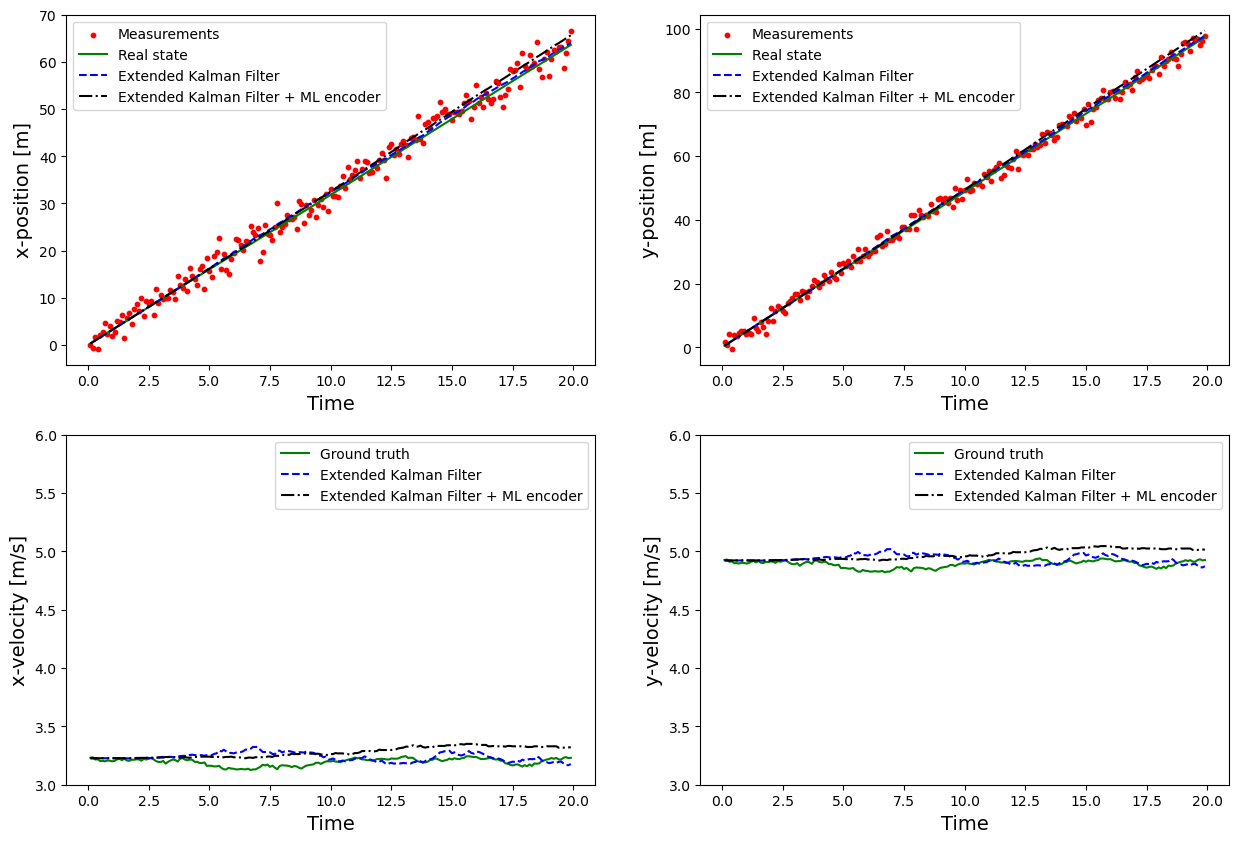

In [110]:
#Exp1
#main

# ML parameters
f=8.6e8
lmb = 3e8/f
print(f'lmb:{lmb}')
ml_resol=2*lmb
std=0.5e0 #extremely important !0.5 is best, 1 is worse (larger, worse)
# array paramters
N=10 # number of elements
d=0.25*lmb # distance between 2 adjacent elements
arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location

#EXP
N_exp1=5
Length= 200
obs_list=np.zeros([N_exp1,Length,2])
KF_list=np.zeros([N_exp1,Length,2])
KF_ML_list=np.zeros([N_exp1,Length,2])
for i in range(N_exp1):
    
    # Trajectory Parameters
    v_x=np.random.uniform(3,4)
    v_y=np.random.uniform(4,5)
    X0=np.array([0,0,v_x,v_y]).reshape(4,1)

    dt = 0.1
    F = np.array([[1, 0, dt, 0], [0, 1, 0, dt],[0,0,1,0],[0,0,0,1]])
    H=np.array([[1.,0,0,0],[0,1,0,0]])  
    # Process Noise Covariance
    sv = 0.1
    G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])
    Q = G*G.T*sv**2
    Q = np.array(Q)
    R = 3.*np.eye(2)
    
    
    #init
    x0_EKF = X0
    P0_EKF=np.zeros([4,4])

    real_state, measurements, Phases = GenerateTraj(Length,dt,X0,H,F,Q,R)
    z,filter_result = Contant_velocity_EKF_ML(itr=Length,dt=dt,x0=x0_EKF,P0=P0_EKF,F=F,H=H,Q=Q,R=R,
                                                    lmb=lmb,ml_resol=ml_resol,std=std,arr=arr,flag=1)
    #EKF + ML encoder
    #ML Encoder mse
#     phase_pre=Calcphases(z, arr,lmb,0)
    
    #
#     R_EKF=np.array([[ML_MSE_x,0],[0,ML_MSE_y]])
    R_EKF=R
    z_ML,filter_result_ML = Contant_velocity_EKF_ML(itr=Length,dt=dt,x0=x0_EKF,P0=P0_EKF,F=F,H=H,Q=Q,R=R_EKF,
                                                    lmb=lmb,ml_resol=ml_resol,std=std,arr=arr,flag=2)

    
    #plotting result
    if(i==0):
        plot_result_compare(measurements,real_state,filter_result,filter_result_ML)
        plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_6/EKF_ML_result.png')
        
    # Storing 
    obs_list[i,:,:]=measurements[:,0:2].reshape(Length,2)
    KF_list[i,:,:]=filter_result[:,0:2].reshape(Length,2)
    KF_ML_list[i,:,:]=filter_result_ML[:,0:2].reshape(Length,2)


obs_list=obs_list.reshape(-1,2)
KF_list=KF_list.reshape(-1,2)
KF_ML_list=KF_ML_list.reshape(-1,2)
KF_MSE=MSE_error(obs_list,KF_list)
KF_ML_MSE=MSE_error(obs_list,KF_ML_list)
print(KF_MSE,KF_ML_MSE)

In [107]:
def todB(x):
    return 10*np.log(x)/np.log(10)

In [108]:
print(f'KF_MSE:{todB(KF_MSE)}[dB],KF_ML_MSE:{todB(KF_ML_MSE)}[dB]')

KF_MSE:-9.459277929536713[dB],KF_ML_MSE:-4.5914926531037485[dB]
